### 1. Import libraries

In [114]:
import numpy as np
import pandas as pd
import os, os.path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import cv2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import imutils
import time
import glob as glob
from ultralytics import YOLO
from ultralytics.utils.plotting import colors
from PIL import Image
from torchvision import transforms
from torch.serialization import add_safe_globals

### 2. Count the number of images and videos in the directories

In [2]:
#Print the numbers of images
DIR1 = './Images'
DIR2 = './Videos'

No_of_images = sum([len(files) for _, _, files in os.walk(DIR1)])
print("Number of images in the directory: ", No_of_images)
No_of_videos = sum([len(files) for _, _, files in os.walk(DIR2)])
print("Number of videos in the directory: ", No_of_videos)

Number of images in the directory:  402
Number of videos in the directory:  0


### 3. Human Detection using YOLO COCO


image 1/1 /Users/lahungthinh/Documents/Final Project/Code/Images/not_fighting/2.jpg: 640x448 2 persons, 49.4ms
Speed: 3.3ms preprocess, 49.4ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 448)
Person detected: box=[80, 143, 157, 389], confidence=0.93
Person detected: box=[157, 161, 237, 389], confidence=0.92


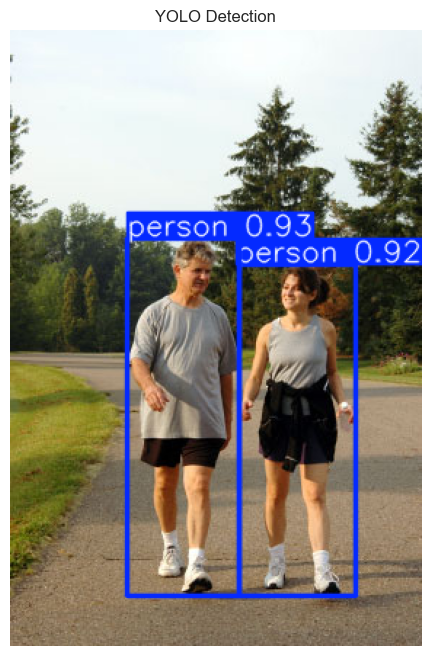

In [3]:
model = YOLO("yolo11n.pt")

results = model('Images/not_fighting/2.jpg')
for result in results:  # results is a list where each item corresponds to one image
    boxes = result.boxes  # Bounding boxes for all detected objects
    for box in boxes:
        class_id = int(box.cls)
        if model.names[class_id] == 'person':
            # Convert box coordinates to integers for drawing
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf)
            print(f"Person detected: box={[x1, y1, x2, y2]}, confidence={conf:.2f}")

# To display the image with detections
img = cv2.imread('Images/not_fighting/2.jpg')
res_plotted = results[0].plot()  # This automatically plots the detection results

# Display using matplotlib (recommended for Jupyter)
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('YOLO Detection')
plt.show()

In [ ]:
# Run the model on all images in the non_fighting folder, plot them and save the plot image into another directory
input_dir = './Images/not_fighting'
output_dir = './Processed_Images/not_fighting'
model = YOLO("yolo11n.pt")

os.makedirs(output_dir, exist_ok=True)

for root, _, files in os.walk(input_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            file_path = os.path.join(root, file)

            results = model(file_path)           # faster to pass the path
            res      = results[0]                # one image → one Results obj
            annotated = res.plot()               # numpy array, BGR
            full_out  = os.path.join(
                output_dir, f'{os.path.splitext(file)[0]}_det.jpg')
            cv2.imwrite(full_out, annotated)
            print('Saved annotated frame:', full_out)

In [ ]:
# Run the model on all images in the fighting folder, plot them and save the plot image into another directory
input_dir = './Images/fighting'
output_dir = './Processed_Images/fighting'
model = YOLO("yolo11n.pt")

os.makedirs(output_dir, exist_ok=True)

for root, _, files in os.walk(input_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            file_path = os.path.join(root, file)

            results = model(file_path)           # faster to pass the path
            res      = results[0]                # one image → one Results obj
            annotated = res.plot()               # numpy array, BGR
            full_out  = os.path.join(
                output_dir, f'{os.path.splitext(file)[0]}_det.jpg')
            cv2.imwrite(full_out, annotated)
            print('Saved annotated frame:', full_out)

***Calculate the overlapping of the bounding boxes (Intersection)***

In [6]:
def compute_overlap_percentage(box1, box2):
    """
    Calculate the overlap percentage between two bounding boxes.
    Returns the percentage of overlap relative to the smaller box.

    Args:
        box1, box2: [x1, y1, x2, y2] format

    Returns:
        float: Overlap percentage (0.0 to 1.0)
    """
    # Calculate intersection coordinates
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    # Check if there's any intersection
    if x1_inter >= x2_inter or y1_inter >= y2_inter:
        return 0.0

    # Calculate intersection area
    intersection_area = (x2_inter - x1_inter) * (y2_inter - y1_inter)

    # Calculate areas of both boxes
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Use the smaller box as reference for percentage calculation
    smaller_area = min(area1, area2)

    # Return overlap percentage relative to smaller box
    if smaller_area == 0:
        return 0.0

    return intersection_area / smaller_area

def compute_horizontal_overlap_percentage(box1, box2):
    """
    Calculate horizontal overlap percentage between two boxes.
    Useful for detecting side-by-side interactions.
    """
    x1_inter = max(box1[0], box2[0])
    x2_inter = min(box1[2], box2[2])

    if x1_inter >= x2_inter:
        return 0.0

    overlap_width = x2_inter - x1_inter
    width1 = box1[2] - box1[0]
    width2 = box2[2] - box2[0]
    smaller_width = min(width1, width2)

    return overlap_width / smaller_width if smaller_width > 0 else 0.0

def compute_vertical_overlap_percentage(box1, box2):
    """
    Calculate vertical overlap percentage between two boxes.
    Useful for detecting height-based interactions.
    """
    y1_inter = max(box1[1], box2[1])
    y2_inter = min(box1[3], box2[3])

    if y1_inter >= y2_inter:
        return 0.0

    overlap_height = y2_inter - y1_inter
    height1 = box1[3] - box1[1]
    height2 = box2[3] - box2[1]
    smaller_height = min(height1, height2)

    return overlap_height / smaller_height if smaller_height > 0 else 0.0

def detect_fight(img_path, model,
                overlap_threshold=0.3,      # 15% overlap threshold (was 0.15)
                horizontal_threshold=0.6,    # 30% horizontal overlap (was 0.3)
                vertical_threshold=0.7,      # 50% vertical overlap (was 0.5)
                distance_threshold=75,      # pixel distance between centers (was 100)
                expand_ratio=0.05,           # box expansion ratio (was 0.1)
                min_box_area=1000):          # minimum box area to consider (was 500)
    """
    Enhanced fight detection using percentage-based overlap analysis.

    Args:
        img_path (str): Path to the image
        model: YOLO model object
        overlap_threshold (float): Overall overlap percentage threshold (0.0-1.0)
        horizontal_threshold (float): Horizontal overlap percentage threshold
        vertical_threshold (float): Vertical overlap percentage threshold
        distance_threshold (int): Maximum distance between box centers (pixels)
        expand_ratio (float): How much to expand bounding boxes
        min_box_area (int): Minimum box area to consider valid detection

    Returns:
        tuple: (is_fight: bool, detection_info: dict)
    """
    results = model(img_path)
    person_boxes = []

    # Extract person detections
    for r in results:
        for box in r.boxes:
            if int(box.cls) == 0:  # person class
                x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())

                # Filter out very small detections
                box_area = (x2 - x1) * (y2 - y1)
                if box_area >= min_box_area:
                    person_boxes.append([x1, y1, x2, y2])

    if len(person_boxes) < 2:
        return False, {"reason": "insufficient_people", "person_count": len(person_boxes)}

    # Expand bounding boxes (because people might throw punch outside of their body box)
    expanded_boxes = []
    for (x1, y1, x2, y2) in person_boxes:
        w, h = x2 - x1, y2 - y1
        x1_exp = max(0, x1 - int(w * expand_ratio))
        y1_exp = max(0, y1 - int(h * expand_ratio))
        x2_exp = x2 + int(w * expand_ratio)
        y2_exp = y2 + int(h * expand_ratio)
        expanded_boxes.append([x1_exp, y1_exp, x2_exp, y2_exp])

    # Analyze all pairs of people
    max_overlap = 0.0
    max_horizontal = 0.0
    max_vertical = 0.0
    min_distance = float('inf')
    fight_detected = False
    detection_details = []

    for i in range(len(expanded_boxes)):
        for j in range(i + 1, len(expanded_boxes)):
            box1, box2 = expanded_boxes[i], expanded_boxes[j]

            # Calculate different overlap metrics
            overall_overlap = compute_overlap_percentage(box1, box2)
            horizontal_overlap = compute_horizontal_overlap_percentage(box1, box2)
            vertical_overlap = compute_vertical_overlap_percentage(box1, box2)

            # Calculate distance between centers
            cx1 = (box1[0] + box1[2]) / 2
            cy1 = (box1[1] + box1[3]) / 2
            cx2 = (box2[0] + box2[2]) / 2
            cy2 = (box2[1] + box2[3]) / 2
            distance = ((cx1 - cx2)**2 + (cy1 - cy2)**2) ** 0.5

            # Track maximums
            max_overlap = max(max_overlap, overall_overlap)
            max_horizontal = max(max_horizontal, horizontal_overlap)
            max_vertical = max(max_vertical, vertical_overlap)
            min_distance = min(min_distance, distance)

            # Store details for this pair
            pair_info = {
                'pair': (i, j),
                'overall_overlap': overall_overlap,
                'horizontal_overlap': horizontal_overlap,
                'vertical_overlap': vertical_overlap,
                'distance': distance
            }
            detection_details.append(pair_info)

            # Fight detection logic - multiple criteria
            fight_conditions = [
                overall_overlap >= overlap_threshold,
                (horizontal_overlap >= horizontal_threshold and
                 vertical_overlap >= vertical_threshold),
                (distance <= distance_threshold and overall_overlap > 0.05)
            ]

            if any(fight_conditions):
                fight_detected = True
                pair_info['fight_reason'] = []
                if overall_overlap >= overlap_threshold:
                    pair_info['fight_reason'].append(f"high_overlap_{overall_overlap:.3f}")
                if (horizontal_overlap >= horizontal_threshold and
                    vertical_overlap >= vertical_threshold):
                    pair_info['fight_reason'].append(f"significant_h{horizontal_overlap:.3f}_v{vertical_overlap:.3f}")
                if (distance <= distance_threshold and overall_overlap > 0.05):
                    pair_info['fight_reason'].append(f"close_distance_{distance:.1f}")

    # Compile detection info
    detection_info = {
        "fight_detected": fight_detected,
        "person_count": len(person_boxes),
        "max_overall_overlap": max_overlap,
        "max_horizontal_overlap": max_horizontal,
        "max_vertical_overlap": max_vertical,
        "min_distance": min_distance,
        "person_boxes": person_boxes,
        "expanded_boxes": expanded_boxes,
        "pair_details": detection_details,
        "thresholds_used": {
            "overlap": overlap_threshold,
            "horizontal": horizontal_threshold,
            "vertical": vertical_threshold,
            "distance": distance_threshold
        }
    }

    return fight_detected, detection_info

# Helper function to print detailed results
def print_fight_analysis(img_path, detection_info):
    """Print detailed analysis of fight detection results"""
    info = detection_info
    print(f"\n--- Analysis for {img_path} ---")
    print(f"Fight Detected: {info['fight_detected']}")
    print(f"People Found: {info['person_count']}")
    print(f"Max Overall Overlap: {info['max_overall_overlap']:.3f}")
    print(f"Max Horizontal Overlap: {info['max_horizontal_overlap']:.3f}")
    print(f"Max Vertical Overlap: {info['max_vertical_overlap']:.3f}")
    print(f"Min Distance: {info['min_distance']:.1f} pixels")

    if info['fight_detected']:
        print("\nFight indicators:")
        for pair in info['pair_details']:
            if 'fight_reason' in pair:
                print(f"  Pair {pair['pair']}: {', '.join(pair['fight_reason'])}")


In [7]:
# Test the improved detect_fight function on a sample image
img_path = "Processed_Images/fighting/2_det.jpg"
fight_detected, info = detect_fight(img_path, model)
print_fight_analysis(img_path, info)


image 1/1 /Users/lahungthinh/Documents/Final Project/Code/Processed_Images/fighting/2_det.jpg: 480x640 4 persons, 1 horse, 47.0ms
Speed: 2.0ms preprocess, 47.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

--- Analysis for Processed_Images/fighting/2_det.jpg ---
Fight Detected: True
People Found: 4
Max Overall Overlap: 1.000
Max Horizontal Overlap: 1.000
Max Vertical Overlap: 1.000
Min Distance: 126.1 pixels

Fight indicators:
  Pair (0, 1): high_overlap_1.000, significant_h1.000_v1.000
  Pair (1, 3): high_overlap_1.000, significant_h1.000_v1.000


In [8]:
# Loop over all images and collect results for evaluation

# Lists to store results
all_true_labels = []
all_predicted_labels = []
all_filenames = []

print("Processing fighting images...")
fighting_dir = './Images/fighting'
fighting_files = [f for f in os.listdir(fighting_dir)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

for i, filename in enumerate(fighting_files):
    img_path = os.path.join(fighting_dir, filename)
    try:
        fight_detected, detection_info = detect_fight(img_path, model)

        all_true_labels.append(1)  # True label: Fighting
        all_predicted_labels.append(1 if fight_detected else 0)
        all_filenames.append(f"fighting/{filename}")

        if (i + 1) % 20 == 0:
            print(f"  Processed {i + 1}/{len(fighting_files)} fighting images")

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        continue

print("\nProcessing not-fighting images...")
not_fighting_dir = './Images/not_fighting'
not_fighting_files = [f for f in os.listdir(not_fighting_dir)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

for i, filename in enumerate(not_fighting_files):
    img_path = os.path.join(not_fighting_dir, filename)
    try:
        fight_detected, detection_info = detect_fight(img_path, model)

        all_true_labels.append(0)  # True label: Not Fighting
        all_predicted_labels.append(1 if fight_detected else 0)
        all_filenames.append(f"not_fighting/{filename}")

        if (i + 1) % 20 == 0:
            print(f"  Processed {i + 1}/{len(not_fighting_files)} not-fighting images")

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        continue

print(f"\nTotal images processed: {len(all_true_labels)}")
print(f"Fighting images: {len(fighting_files)}")
print(f"Not-fighting images: {len(not_fighting_files)}")


Processing fighting images...

image 1/1 /Users/lahungthinh/Documents/Final Project/Code/Images/fighting/77.jpg: 384x640 2 persons, 2 sports balls, 40.3ms
Speed: 1.6ms preprocess, 40.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/lahungthinh/Documents/Final Project/Code/Images/fighting/88.jpg: 384x640 2 persons, 33.4ms
Speed: 1.0ms preprocess, 33.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/lahungthinh/Documents/Final Project/Code/Images/fighting/x2.jpg: 576x640 3 persons, 51.4ms
Speed: 1.6ms preprocess, 51.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /Users/lahungthinh/Documents/Final Project/Code/Images/fighting/gettyimages-1134173933-2048x2048.jpg: 448x640 2 persons, 38.1ms
Speed: 1.7ms preprocess, 38.1ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /Users/lahungthinh/Documents/Final Project/Code/Images/fighting/gettyimages-926714996-204


Overall Accuracy: 0.5950

Classification Report:
              precision    recall  f1-score   support

Not Fighting       0.62      0.51      0.55       200
    Fighting       0.58      0.69      0.63       200

    accuracy                           0.59       400
   macro avg       0.60      0.59      0.59       400
weighted avg       0.60      0.59      0.59       400


Confusion Matrix:
[[101  99]
 [ 63 137]]


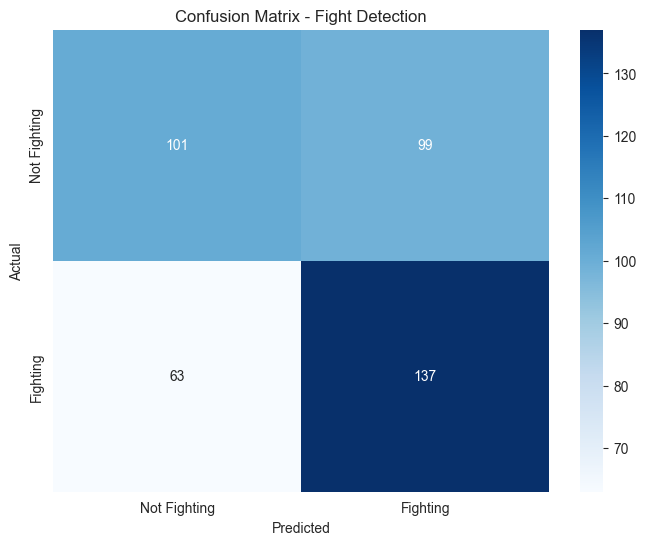


Detailed Results:
True Positives (Correctly detected fights): 137
True Negatives (Correctly detected non-fights): 101
False Positives (Non-fights detected as fights): 99
False Negatives (Fights missed): 63

False Positive Rate: 0.4950
False Negative Rate: 0.3150


In [9]:
# Generate classification report and confusion matrix

# Calculate accuracy
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
print(f"\nOverall Accuracy: {accuracy:.4f}")

# Generate classification report
class_names = ['Not Fighting', 'Fighting']
print("\nClassification Report:")
print(classification_report(all_true_labels, all_predicted_labels, target_names=class_names))

# Generate confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Fight Detection')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print some error analysis
tn, fp, fn, tp = conf_matrix.ravel()
print(f"\nDetailed Results:")
print(f"True Positives (Correctly detected fights): {tp}")
print(f"True Negatives (Correctly detected non-fights): {tn}")
print(f"False Positives (Non-fights detected as fights): {fp}")
print(f"False Negatives (Fights missed): {fn}")

if fp > 0:
    print(f"\nFalse Positive Rate: {fp/(fp+tn):.4f}")
if fn > 0:
    print(f"False Negative Rate: {fn/(fn+tp):.4f}")


### CNN Training with PyTorch ResNet50

In [10]:
# Import additional libraries for CNN training
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
import shutil
from PIL import Image
import copy
import random

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cpu


In [37]:
# Data preparation - Create train/val/test splits
def prepare_cnn_data(source_dir, target_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Prepare data splits for CNN training
    """
    # Create target directory structure
    splits = ['train', 'val', 'test']
    classes = ['fighting', 'not_fighting']

    for split in splits:
        for class_name in classes:
            os.makedirs(os.path.join(target_dir, split, class_name), exist_ok=True)

    # Process each class
    all_files_info = []

    for class_name in classes:
        class_path = os.path.join(source_dir, class_name)
        if os.path.exists(class_path):
            files = [f for f in os.listdir(class_path)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

            # Shuffle files
            random.shuffle(files)

            # Calculate split sizes
            total_files = len(files)
            train_size = int(total_files * train_ratio)
            val_size = int(total_files * val_ratio)

            # Split files
            train_files = files[:train_size]
            val_files = files[train_size:train_size + val_size]
            test_files = files[train_size + val_size:]

            # Copy files to appropriate directories
            for split, file_list in [('train', train_files), ('val', val_files), ('test', test_files)]:
                for file in file_list:
                    src = os.path.join(class_path, file)
                    dst = os.path.join(target_dir, split, class_name, file)
                    shutil.copy2(src, dst)

            all_files_info.append({
                'class': class_name,
                'total': total_files,
                'train': len(train_files),
                'val': len(val_files),
                'test': len(test_files)
            })

            print(f"{class_name}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

    return all_files_info

# Prepare the data splits
cnn_data_dir = './CNN_Data'
data_info = prepare_cnn_data('./Images', cnn_data_dir)

print(f"\nData preparation complete!")
print(f"CNN training data saved to: {cnn_data_dir}")

fighting: 140 train, 30 val, 30 test
not_fighting: 140 train, 30 val, 30 test

Data preparation complete!
CNN training data saved to: ./CNN_Data


In [38]:
# Define data transforms with augmentation
# Training transforms (with augmentation - CLEARLY DIFFERENT FROM NORMAL DATA)
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Validation and test transforms (NO AUGMENTATION - NORMAL DATA)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = ImageFolder(root=os.path.join(cnn_data_dir, 'train'), transform=train_transforms)
val_dataset = ImageFolder(root=os.path.join(cnn_data_dir, 'val'), transform=val_test_transforms)
test_dataset = ImageFolder(root=os.path.join(cnn_data_dir, 'test'), transform=val_test_transforms)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Class names: {train_dataset.classes}")
print(f"Class indices: {train_dataset.class_to_idx}")

Training samples: 396
Validation samples: 196
Test samples: 192
Class names: ['fighting', 'not_fighting']
Class indices: {'fighting': 0, 'not_fighting': 1}


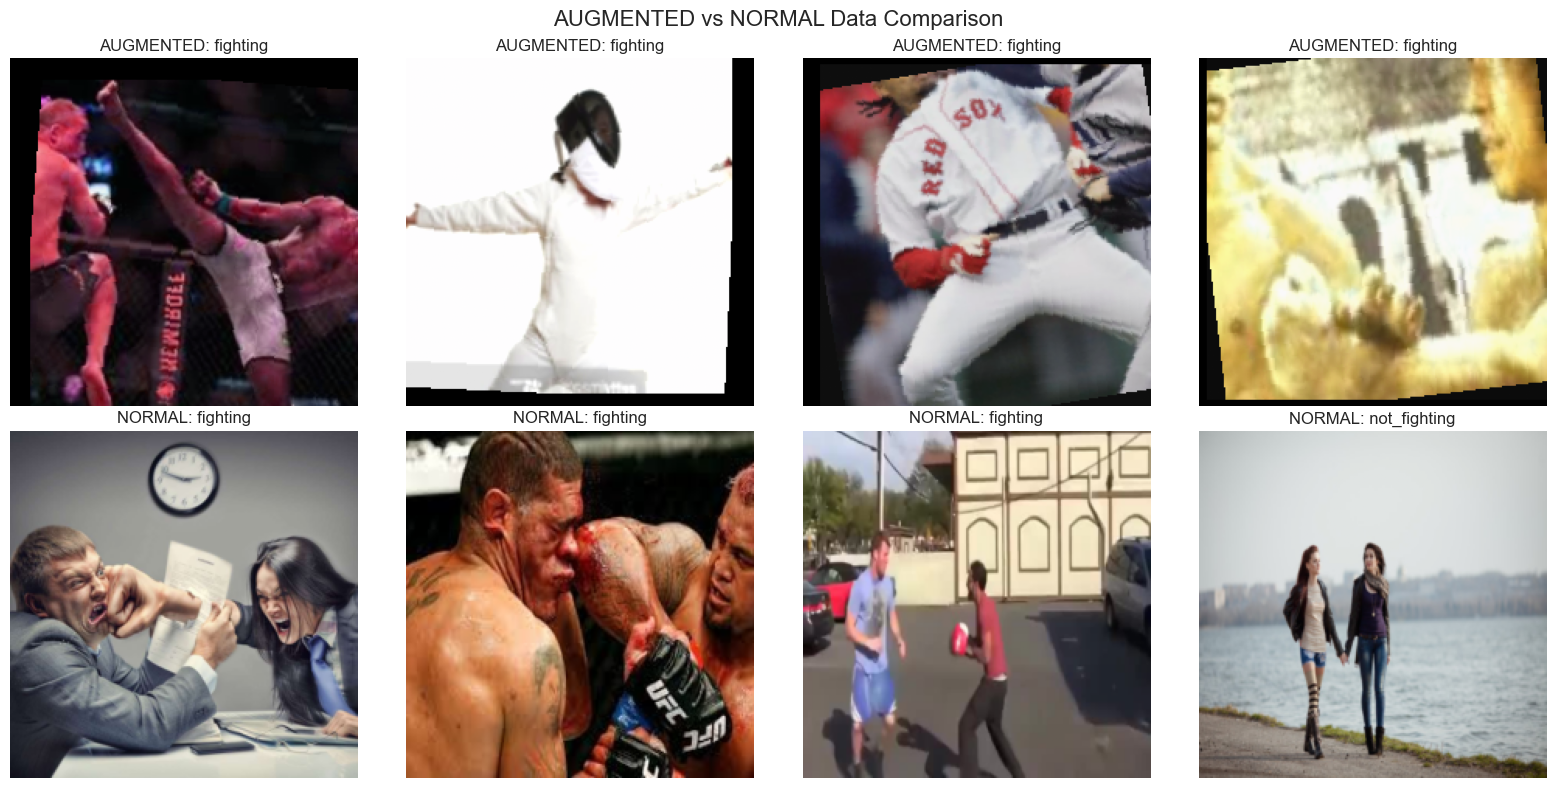

In [39]:
# Visualize augmented vs normal samples to see the difference
def visualize_augmented_vs_normal(train_dataset, val_dataset, num_samples=4):
    """Show difference between augmented training data and normal validation data"""
    fig, axes = plt.subplots(2, num_samples, figsize=(16, 8))

    # Get same images from both datasets (they should have same images, different transforms)
    indices = random.sample(range(min(len(train_dataset), len(val_dataset))), num_samples)

    for i, idx in enumerate(indices):
        # Get augmented version
        aug_image, aug_label = train_dataset[idx]
        # Get normal version
        normal_image, normal_label = val_dataset[idx]

        # Denormalize for visualization
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])

        aug_image = aug_image * std.view(3, 1, 1) + mean.view(3, 1, 1)
        aug_image = torch.clamp(aug_image, 0, 1)

        normal_image = normal_image * std.view(3, 1, 1) + mean.view(3, 1, 1)
        normal_image = torch.clamp(normal_image, 0, 1)

        # Plot augmented (top row)
        axes[0, i].imshow(aug_image.permute(1, 2, 0).numpy())
        axes[0, i].set_title(f"AUGMENTED: {train_dataset.classes[aug_label]}")
        axes[0, i].axis('off')

        # Plot normal (bottom row)
        axes[1, i].imshow(normal_image.permute(1, 2, 0).numpy())
        axes[1, i].set_title(f"NORMAL: {val_dataset.classes[normal_label]}")
        axes[1, i].axis('off')

    plt.suptitle('AUGMENTED vs NORMAL Data Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()

# Show the difference between augmented and normal data
visualize_augmented_vs_normal(train_dataset, val_dataset)

In [52]:
# Define ResNet50 model with transfer learning
class FightDetectionCNN(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(FightDetectionCNN, self).__init__()
        weights = torchvision.models.ResNet50_Weights.DEFAULT if pretrained else None
        self.backbone = torchvision.models.resnet50(weights=weights)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
        )
        self.freeze_backbone()

    def freeze_backbone(self):
        for p in self.backbone.parameters():
            p.requires_grad = False
        for p in self.backbone.fc.parameters():
            p.requires_grad = True

    def unfreeze_backbone(self):
        for p in self.backbone.parameters():
            p.requires_grad = True

    def forward(self, x):
        return self.backbone(x)


# Create model
cnn_model = FightDetectionCNN(num_classes=2, pretrained=True)
cnn_model = cnn_model.to(device)

print("CNN Model Created:")
print(f"Total parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in cnn_model.parameters() if p.requires_grad):,}")

CNN Model Created:
Total parameters: 24,558,146
Trainable parameters: 1,050,114


In [53]:
# Training configuration and functions
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        if batch_idx % 10 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}, '
                  f'Acc: {100. * correct / total:.2f}%')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc, all_targets, all_predictions

print("Training functions ready!")

Training functions ready!


In [54]:
# Phase 1: Train classifier only (frozen backbone)
print("="*60)
print("PHASE 1: Training classifier with frozen backbone")
print("="*60)

num_epochs_phase1 = 10
train_losses_p1 = []
train_accs_p1 = []
val_losses_p1 = []
val_accs_p1 = []

best_val_acc_p1 = 0.0
best_model_p1 = None

for epoch in range(num_epochs_phase1):
    print(f'\nEpoch {epoch+1}/{num_epochs_phase1}')
    print('-' * 30)

    # Training
    train_loss, train_acc = train_epoch(cnn_model, train_loader, criterion, optimizer, device)
    train_losses_p1.append(train_loss)
    train_accs_p1.append(train_acc)

    # Validation
    val_loss, val_acc, _, _ = validate_epoch(cnn_model, val_loader, criterion, device)
    val_losses_p1.append(val_loss)
    val_accs_p1.append(val_acc)

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Save best model
    if val_acc > best_val_acc_p1:
        best_val_acc_p1 = val_acc
        best_model_p1 = copy.deepcopy(cnn_model.state_dict())
        print(f'New best validation accuracy: {val_acc:.2f}%')

    scheduler.step()

print(f"\nPhase 1 completed! Best validation accuracy: {best_val_acc_p1:.2f}%")

PHASE 1: Training classifier with frozen backbone

Epoch 1/10
------------------------------
Batch 0/13, Loss: 0.7016, Acc: 46.88%
Batch 10/13, Loss: 0.4696, Acc: 69.60%
Train Loss: 0.5450, Train Acc: 70.96%
Val Loss: 0.1639, Val Acc: 94.39%
New best validation accuracy: 94.39%

Epoch 2/10
------------------------------
Batch 0/13, Loss: 0.4246, Acc: 81.25%
Batch 10/13, Loss: 0.2317, Acc: 87.78%
Train Loss: 0.3151, Train Acc: 87.88%
Val Loss: 0.0739, Val Acc: 96.94%
New best validation accuracy: 96.94%

Epoch 3/10
------------------------------
Batch 0/13, Loss: 0.2603, Acc: 90.62%
Batch 10/13, Loss: 0.1421, Acc: 90.62%
Train Loss: 0.2154, Train Acc: 90.91%
Val Loss: 0.0546, Val Acc: 97.45%
New best validation accuracy: 97.45%

Epoch 4/10
------------------------------
Batch 0/13, Loss: 0.2960, Acc: 90.62%
Batch 10/13, Loss: 0.1338, Acc: 91.48%
Train Loss: 0.2137, Train Acc: 91.92%
Val Loss: 0.0940, Val Acc: 95.41%

Epoch 5/10
------------------------------
Batch 0/13, Loss: 0.2288, Ac

In [55]:
# Phase 2: Fine-tune entire model
print("="*60)
print("PHASE 2: Fine-tuning entire model")
print("="*60)

# Load best model from phase 1
cnn_model.load_state_dict(best_model_p1)

# Unfreeze backbone for fine-tuning
cnn_model.unfreeze_backbone()

# Lower learning rate for fine-tuning
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs_phase2 = 15
train_losses_p2 = []
train_accs_p2 = []
val_losses_p2 = []
val_accs_p2 = []

best_val_acc_p2 = best_val_acc_p1
best_model_p2 = None

for epoch in range(num_epochs_phase2):
    print(f'\nEpoch {epoch+1}/{num_epochs_phase2}')
    print('-' * 30)

    # Training
    train_loss, train_acc = train_epoch(cnn_model, train_loader, criterion, optimizer, device)
    train_losses_p2.append(train_loss)
    train_accs_p2.append(train_acc)

    # Validation
    val_loss, val_acc, _, _ = validate_epoch(cnn_model, val_loader, criterion, device)
    val_losses_p2.append(val_loss)
    val_accs_p2.append(val_acc)

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Save best model
    if val_acc > best_val_acc_p2:
        best_val_acc_p2 = val_acc
        best_model_p2 = copy.deepcopy(cnn_model.state_dict())
        print(f'New best validation accuracy: {val_acc:.2f}%')

    scheduler.step()

print(f"\nPhase 2 completed! Best validation accuracy: {best_val_acc_p2:.2f}%")

# Save the best model
# Load best weights into the model, then save FULL model (so you can torch.load(...).eval())
if best_model_p2 is not None:
    cnn_model.load_state_dict(best_model_p2)

torch.save(cnn_model, 'best_fight_detection_cnn.pth')  # full model for easy inference
# Optional: also keep a pure state\_dict if needed
# torch.save(cnn_model.state_dict(), 'best_fight_detection_cnn_state.pth')

print("Best model saved as 'best_fight_detection_cnn.pth'")

PHASE 2: Fine-tuning entire model

Epoch 1/15
------------------------------
Batch 0/13, Loss: 0.2845, Acc: 81.25%
Batch 10/13, Loss: 0.0800, Acc: 92.05%
Train Loss: 0.1672, Train Acc: 92.42%
Val Loss: 0.0397, Val Acc: 97.45%

Epoch 2/15
------------------------------
Batch 0/13, Loss: 0.2302, Acc: 93.75%
Batch 10/13, Loss: 0.1097, Acc: 94.89%
Train Loss: 0.1233, Train Acc: 94.95%
Val Loss: 0.0136, Val Acc: 99.49%

Epoch 3/15
------------------------------
Batch 0/13, Loss: 0.2499, Acc: 90.62%
Batch 10/13, Loss: 0.1331, Acc: 93.75%
Train Loss: 0.1485, Train Acc: 93.94%
Val Loss: 0.0049, Val Acc: 100.00%

Epoch 4/15
------------------------------
Batch 0/13, Loss: 0.0950, Acc: 96.88%
Batch 10/13, Loss: 0.0789, Acc: 96.31%
Train Loss: 0.1287, Train Acc: 95.96%
Val Loss: 0.0045, Val Acc: 100.00%

Epoch 5/15
------------------------------
Batch 0/13, Loss: 0.0258, Acc: 100.00%
Batch 10/13, Loss: 0.0463, Acc: 95.45%
Train Loss: 0.1693, Train Acc: 95.45%
Val Loss: 0.0034, Val Acc: 100.00%

E

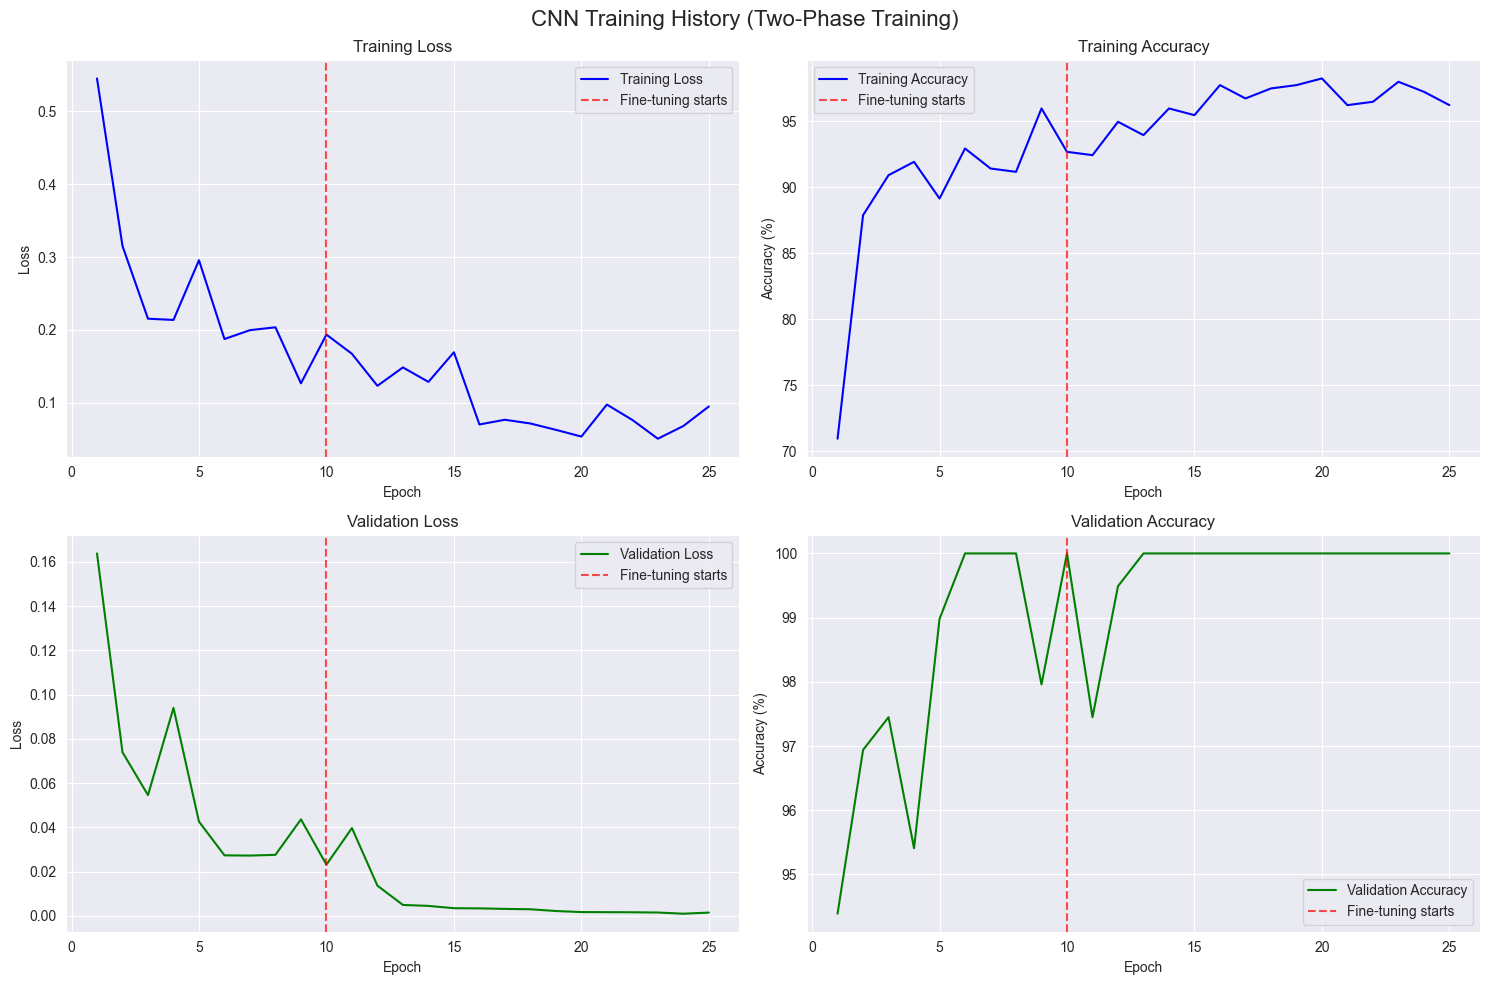

In [56]:
# Plot training history
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Combine both phases for plotting
all_train_losses = train_losses_p1 + train_losses_p2
all_train_accs = train_accs_p1 + train_accs_p2
all_val_losses = val_losses_p1 + val_losses_p2
all_val_accs = val_accs_p1 + val_accs_p2

epochs = range(1, len(all_train_losses) + 1)
phase1_end = len(train_losses_p1)

# Training Loss
ax1.plot(epochs, all_train_losses, 'b-', label='Training Loss')
ax1.axvline(x=phase1_end, color='r', linestyle='--', alpha=0.7, label='Fine-tuning starts')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Training Accuracy
ax2.plot(epochs, all_train_accs, 'b-', label='Training Accuracy')
ax2.axvline(x=phase1_end, color='r', linestyle='--', alpha=0.7, label='Fine-tuning starts')
ax2.set_title('Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

# Validation Loss
ax3.plot(epochs, all_val_losses, 'g-', label='Validation Loss')
ax3.axvline(x=phase1_end, color='r', linestyle='--', alpha=0.7, label='Fine-tuning starts')
ax3.set_title('Validation Loss')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.legend()
ax3.grid(True)

# Validation Accuracy
ax4.plot(epochs, all_val_accs, 'g-', label='Validation Accuracy')
ax4.axvline(x=phase1_end, color='r', linestyle='--', alpha=0.7, label='Fine-tuning starts')
ax4.set_title('Validation Accuracy')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy (%)')
ax4.legend()
ax4.grid(True)

plt.suptitle('CNN Training History (Two-Phase Training)', fontsize=16)
plt.tight_layout()
plt.show()

FINAL CNN EVALUATION ON TEST SET
Info: No Phase-2 improvement; using best Phase-1 weights.
CNN Test Accuracy: 99.48%
CNN Test Loss: 0.0412

CNN Classification Report:
              precision    recall  f1-score   support

    fighting       0.99      1.00      0.99        95
not_fighting       1.00      0.99      0.99        97

    accuracy                           0.99       192
   macro avg       0.99      0.99      0.99       192
weighted avg       0.99      0.99      0.99       192


CNN Confusion Matrix:
[[95  0]
 [ 1 96]]


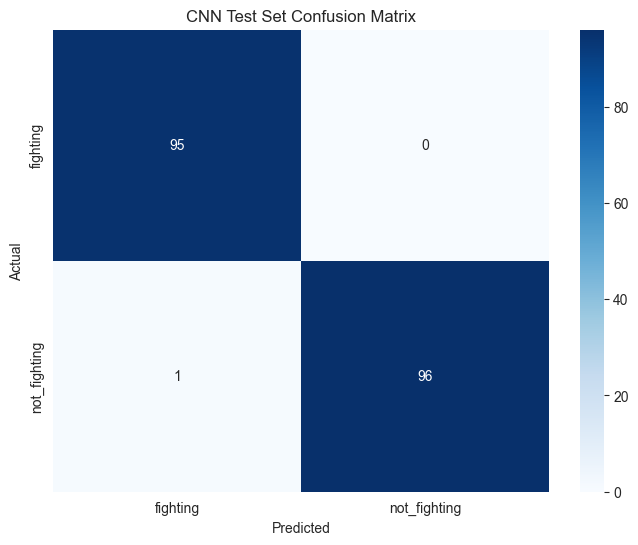


CNN Detailed Metrics:
True Positives: 96
True Negatives: 95
False Positives: 0
False Negatives: 1
Precision: 1.0000
Recall: 0.9897
F1-Score: 0.9948


In [59]:
# Final evaluation on test set (robust to None best_model_p2)

print("="*60)
print("FINAL CNN EVALUATION ON TEST SET")
print("="*60)

# Safely load best weights
if 'best_model_p2' in globals() and best_model_p2 is not None:
    cnn_model.load_state_dict(best_model_p2)
elif 'best_model_p1' in globals() and best_model_p1 is not None:
    print("Info: No Phase-2 improvement; using best Phase-1 weights.")
    cnn_model.load_state_dict(best_model_p1)
else:
    print("Warning: No saved best weights; evaluating current model parameters.")

# Test evaluation
test_loss, test_acc, test_targets, test_predictions = validate_epoch(
    cnn_model, test_loader, criterion, device
)

print(f"CNN Test Accuracy: {test_acc:.2f}%")
print(f"CNN Test Loss: {test_loss:.4f}")

# Detailed classification report
cnn_class_names = ['fighting', 'not_fighting']
print("\nCNN Classification Report:")
print(classification_report(test_targets, test_predictions, target_names=cnn_class_names))

# Confusion Matrix
cnn_conf_matrix = confusion_matrix(test_targets, test_predictions)
print("\nCNN Confusion Matrix:")
print(cnn_conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cnn_conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=cnn_class_names,
    yticklabels=cnn_class_names
)
plt.title('CNN Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate detailed metrics
tn, fp, fn, tp = cnn_conf_matrix.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\nCNN Detailed Metrics:")
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

In [60]:
# Function to predict on new images with CNN
def predict_image_cnn(model, image_path, transform, device, class_names):
    """Predict fight/no-fight for a single image using CNN"""
    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(outputs, dim=1).item()
        confidence = probabilities[0][predicted_class].item()

    return {
        'predicted_class': class_names[predicted_class],
        'confidence': confidence,
        'probabilities': {
            class_names[0]: probabilities[0][0].item(),
            class_names[1]: probabilities[0][1].item()
        }
    }

# Test CNN predictions on sample images
sample_images = [
    './Images/fighting/32.jpg',
    './Images/not_fighting/best-friends-having-picnic-two-attractive-young-girls-dressed-casual-sitting-blanket-lawn-summer-chatting-57519752.jpg'
]

print("="*60)
print("CNN SAMPLE PREDICTIONS")
print("="*60)

for img_path in sample_images:
    if os.path.exists(img_path):
        cnn_result = predict_image_cnn(cnn_model, img_path, val_test_transforms, device, cnn_class_names)
        print(f"\nImage: {img_path}")
        print(f"CNN Predicted: {cnn_result['predicted_class']}")
        print(f"CNN Confidence: {cnn_result['confidence']:.4f}")
        print(f"CNN Probabilities: {cnn_result['probabilities']}")

CNN SAMPLE PREDICTIONS

Image: ./Images/fighting/32.jpg
CNN Predicted: fighting
CNN Confidence: 0.9841
CNN Probabilities: {'fighting': 0.9841364622116089, 'not_fighting': 0.015863515436649323}

Image: ./Images/not_fighting/best-friends-having-picnic-two-attractive-young-girls-dressed-casual-sitting-blanket-lawn-summer-chatting-57519752.jpg
CNN Predicted: not_fighting
CNN Confidence: 1.0000
CNN Probabilities: {'fighting': 1.3883463907404803e-05, 'not_fighting': 0.9999861717224121}


### Compare YOLO vs CNN Results

In [44]:
# Compare YOLO detect_fight vs CNN predictions on sample images
print("="*80)
print("COMPARISON: YOLO detect_fight vs CNN predictions")
print("="*80)

comparison_results = []

for img_path in sample_images:
    if os.path.exists(img_path):
        print(f"\n{'='*50}")
        print(f"Image: {img_path}")
        print(f"{'='*50}")

        # YOLO detection
        try:
            yolo_fight, yolo_info = detect_fight(img_path, model)  # Your YOLO model
            print(f"\nYOLO Method:")
            print(f"  Predicted: {'Fighting' if yolo_fight else 'Not Fighting'}")
            print(f"  People detected: {yolo_info.get('person_count', 0)}")
            print(f"  Max overlap: {yolo_info.get('max_overall_overlap', 0):.3f}")
            print(f"  Min distance: {yolo_info.get('min_distance', float('inf')):.1f}")
        except Exception as e:
            print(f"\nYOLO Method: Error - {e}")
            yolo_fight = None

        # CNN prediction
        try:
            cnn_result = predict_image_cnn(cnn_model, img_path, val_test_transforms, device, cnn_class_names)
            cnn_fight = cnn_result['predicted_class'] == 'fighting'
            print(f"\nCNN Method:")
            print(f"  Predicted: {cnn_result['predicted_class'].title()}")
            print(f"  Confidence: {cnn_result['confidence']:.4f}")
            print(f"  Fighting probability: {cnn_result['probabilities']['fighting']:.4f}")
        except Exception as e:
            print(f"\nCNN Method: Error - {e}")
            cnn_fight = None

        # Compare results
        if yolo_fight is not None and cnn_fight is not None:
            agreement = yolo_fight == cnn_fight
            print(f"\nAgreement: {'✓ AGREE' if agreement else '✗ DISAGREE'}")

            comparison_results.append({
                'image': img_path,
                'yolo_prediction': yolo_fight,
                'cnn_prediction': cnn_fight,
                'agreement': agreement
            })

print(f"\n{'='*80}")
print("SUMMARY COMPARISON")
print(f"{'='*80}")
if comparison_results:
    agreements = sum(1 for r in comparison_results if r['agreement'])
    total = len(comparison_results)
    print(f"Agreement rate: {agreements}/{total} ({100*agreements/total:.1f}%)")

    for result in comparison_results:
        status = "✓" if result['agreement'] else "✗"
        print(f"{status} {result['image']}: YOLO={result['yolo_prediction']}, CNN={result['cnn_prediction']}")
else:
    print("No valid comparisons could be made.")


COMPARISON: YOLO detect_fight vs CNN predictions

Image: ./Images/fighting/32.jpg

image 1/1 /Users/lahungthinh/Documents/Final Project/Code/Images/fighting/32.jpg: 544x640 2 persons, 68.8ms
Speed: 2.1ms preprocess, 68.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

YOLO Method:
  Predicted: Fighting
  People detected: 2
  Max overlap: 0.319
  Min distance: 98.5

CNN Method:
  Predicted: Fighting
  Confidence: 0.9999
  Fighting probability: 0.9999

Agreement: ✓ AGREE

Image: ./Images/not_fighting/best-friends-having-picnic-two-attractive-young-girls-dressed-casual-sitting-blanket-lawn-summer-chatting-57519752.jpg

image 1/1 /Users/lahungthinh/Documents/Final Project/Code/Images/not_fighting/best-friends-having-picnic-two-attractive-young-girls-dressed-casual-sitting-blanket-lawn-summer-chatting-57519752.jpg: 448x640 2 persons, 1 orange, 45.5ms
Speed: 1.3ms preprocess, 45.5ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

YOLO Method:
  Predicted

### Additional Models for Comparison: Basic CNN and ANN

In [23]:
# Transformations for CNN
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # normalize to [-1, 1]
])

dataset = datasets.ImageFolder("./Processed_Images", transform=transform)

# Split into train/val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [24]:
# CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # First Layer
            nn.Conv2d(3, 32, 3, padding=1),  # (128,128,3) -> (32,128,128)
            nn.ReLU(),
            nn.MaxPool2d(2,2),               # -> (32,64,64)
            # Second Layer
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),               # -> (64,32,32)
            # Third Layer
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)                # -> (128,16,16)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*16*16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [25]:
# ANN model
class SimpleANN(nn.Module):
    def __init__(self):
        super(SimpleANN, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*128*128, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = (outputs > 0.5).int()
            correct += (preds == labels.int()).sum().item()

        acc = correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = (outputs > 0.5).int()
                val_correct += (preds == labels.int()).sum().item()
        val_acc = val_correct / len(val_loader.dataset)

        # Save history
        history["train_loss"].append(train_loss / len(train_loader))
        history["train_acc"].append(acc)
        history["val_loss"].append(val_loss / len(val_loader))
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {acc:.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}")
    return model, history


In [33]:
simple_cnn_model = SimpleCNN()
simple_cnn_model, cnn_history = train_model(simple_cnn_model, train_loader, val_loader, epochs=10)
torch.save(simple_cnn_model.state_dict(), "cnn_best.pth")

simple_ann_model = SimpleANN()
simple_ann_model, ann_history = train_model(simple_ann_model, train_loader, val_loader, epochs=10)
torch.save(simple_ann_model.state_dict(), "ann_best.pth")

Epoch 1/10 - Train Loss: 0.7675, Train Acc: 0.6719, Val Loss: 0.5503, Val Acc: 0.7000
Epoch 2/10 - Train Loss: 0.4954, Train Acc: 0.7750, Val Loss: 0.5194, Val Acc: 0.7750
Epoch 3/10 - Train Loss: 0.4591, Train Acc: 0.8187, Val Loss: 0.6506, Val Acc: 0.7000
Epoch 4/10 - Train Loss: 0.4847, Train Acc: 0.8156, Val Loss: 0.5459, Val Acc: 0.7500
Epoch 5/10 - Train Loss: 0.4510, Train Acc: 0.8187, Val Loss: 0.4624, Val Acc: 0.7875
Epoch 6/10 - Train Loss: 0.3893, Train Acc: 0.8375, Val Loss: 0.4379, Val Acc: 0.7875
Epoch 7/10 - Train Loss: 0.3389, Train Acc: 0.8594, Val Loss: 0.4122, Val Acc: 0.7875
Epoch 8/10 - Train Loss: 0.2927, Train Acc: 0.8844, Val Loss: 0.4984, Val Acc: 0.8375
Epoch 9/10 - Train Loss: 0.2618, Train Acc: 0.9094, Val Loss: 0.3868, Val Acc: 0.8125
Epoch 10/10 - Train Loss: 0.2071, Train Acc: 0.9062, Val Loss: 0.3830, Val Acc: 0.8125
Epoch 1/10 - Train Loss: 3.3910, Train Acc: 0.7219, Val Loss: 5.9790, Val Acc: 0.7625
Epoch 2/10 - Train Loss: 3.7426, Train Acc: 0.7719, V

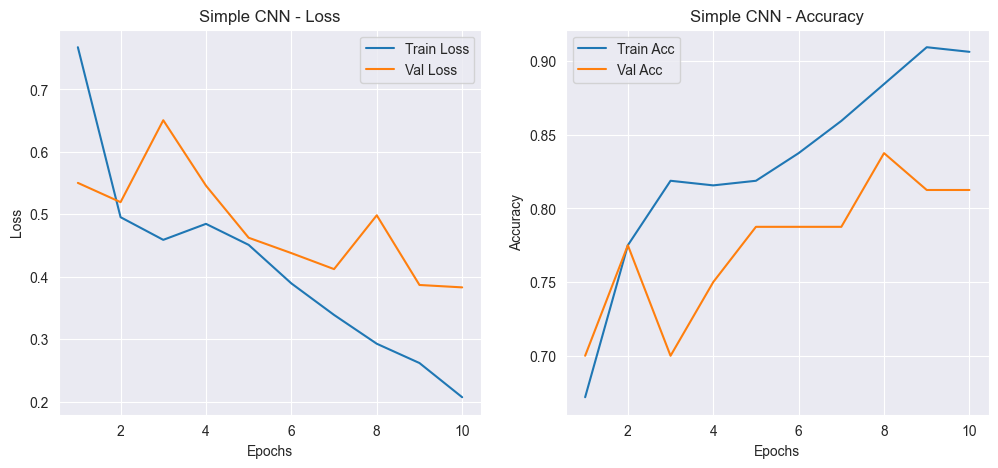

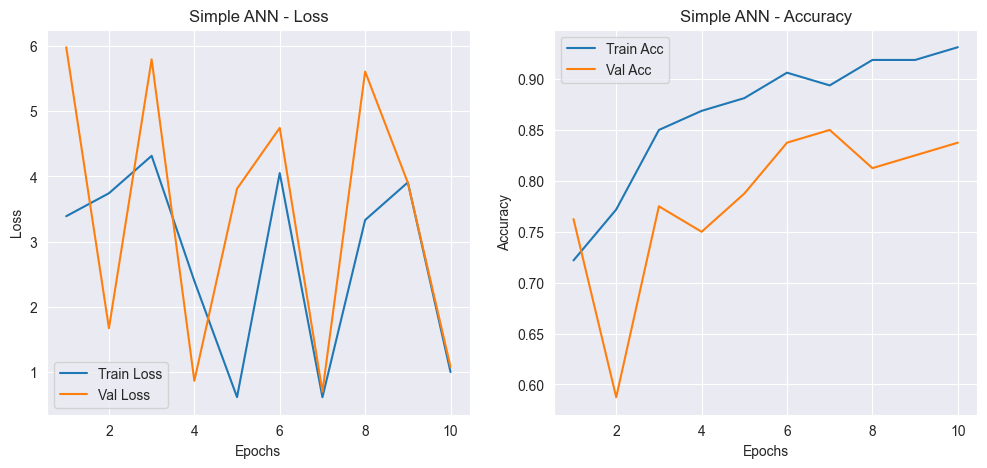

In [34]:
def plot_history(history, title="Model Training"):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs"); plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

plot_history(cnn_history, "Simple CNN")
plot_history(ann_history, "Simple ANN")



Simple CNN Classification Report:

              precision    recall  f1-score   support

   Non-Fight       0.88      0.73      0.80        41
       Fight       0.76      0.90      0.82        39

    accuracy                           0.81        80
   macro avg       0.82      0.81      0.81        80
weighted avg       0.82      0.81      0.81        80



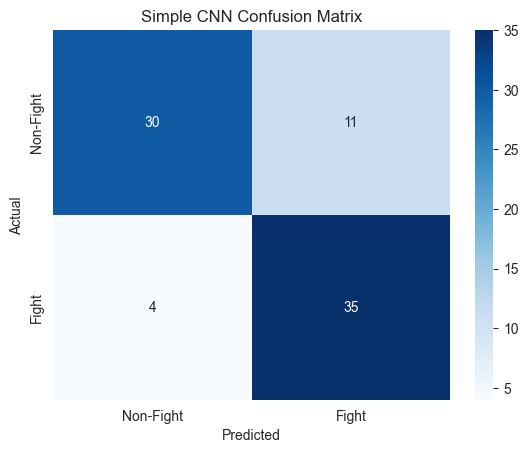


Simple ANN Classification Report:

              precision    recall  f1-score   support

   Non-Fight       0.83      0.85      0.84        41
       Fight       0.84      0.82      0.83        39

    accuracy                           0.84        80
   macro avg       0.84      0.84      0.84        80
weighted avg       0.84      0.84      0.84        80



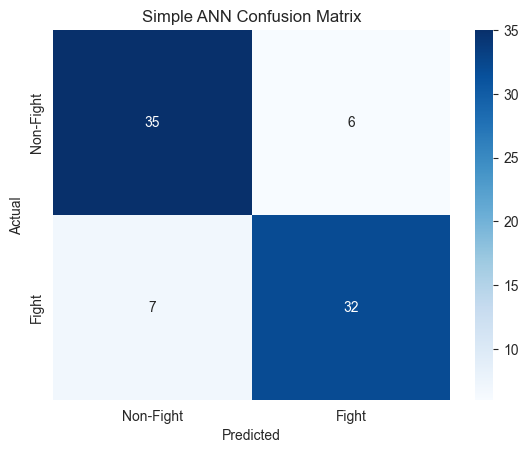

In [35]:
def evaluate_model(model, val_loader, name="Model"):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = (outputs > 0.5).int().cpu().numpy()
            y_pred.extend(preds.flatten())
            y_true.extend(labels.numpy())

    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=["Non-Fight", "Fight"]))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fight", "Fight"], yticklabels=["Non-Fight", "Fight"])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model(simple_cnn_model, val_loader, "Simple CNN")
evaluate_model(simple_ann_model, val_loader, "Simple ANN")

### Frequency analysis

In [134]:
# look at week3_demo.ipynb

### Time frequency analysis

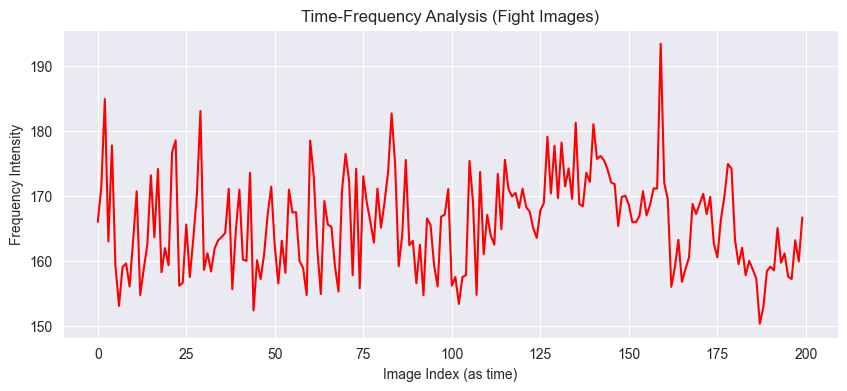

In [111]:
# sort files alphabetically to simulate a time sequence
fight_folder = os.path.join(dataset_path, 'fighting')
files = sorted([f for f in os.listdir(fight_folder) if f.endswith(('.jpg', '.png'))])

freq_values = [image_frequency_score(os.path.join(fight_folder, f)) for f in files]

plt.figure(figsize=(10,4))
plt.plot(freq_values, color='red')
plt.title("Time-Frequency Analysis (Fight Images)")
plt.xlabel("Image Index (as time)")
plt.ylabel("Frequency Intensity")
plt.grid(True)
plt.show()


### Comparing both classes over time

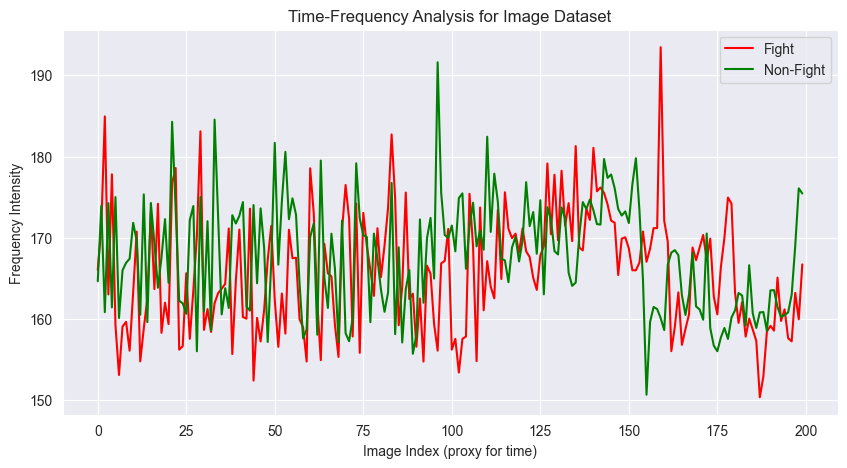

In [113]:
fight_values = [image_frequency_score(os.path.join(dataset_path, 'fighting', f))
                for f in sorted(os.listdir(os.path.join(dataset_path, 'fighting'))) if f.endswith(('.jpg', '.png'))]

nonfight_values = [image_frequency_score(os.path.join(dataset_path, 'not_fighting', f))
                   for f in sorted(os.listdir(os.path.join(dataset_path, 'not_fighting'))) if f.endswith(('.jpg', '.png'))]

plt.figure(figsize=(10,5))
plt.plot(fight_values, label='Fight', color='red')
plt.plot(nonfight_values, label='Non-Fight', color='green')
plt.title("Time-Frequency Analysis for Image Dataset")
plt.xlabel("Image Index (proxy for time)")
plt.ylabel("Frequency Intensity")
plt.legend()
plt.grid(True)
plt.show()


### Detecting videos (deprecated)


In [125]:
MODEL_PATH = "best_fight_detection_cnn.pth"
FRAMES_DIR = "./Processed_Frames/non_fight/video_1"
device = "cpu"

# Allowlist, then load with weights_only=False (trusted local checkpoint)
add_safe_globals([FightDetectionCNN])
ckpt = torch.load(MODEL_PATH, map_location=device, weights_only=False)

if isinstance(ckpt, nn.Module):
    model = ckpt
elif isinstance(ckpt, dict):
    model = FightDetectionCNN(num_classes=2, pretrained=False)
    model.load_state_dict(ckpt, strict=False)
else:
    raise TypeError("Unsupported checkpoint format.")

model.to(device).eval()

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

class_names = ["non_fight", "fight"]

def predict_video_frames(frames_dir: str) -> np.ndarray:
    exts = {".png", ".jpg", ".jpeg", ".bmp"}
    files = [f for f in os.listdir(frames_dir) if os.path.splitext(f)[1].lower() in exts]
    files = [(f, os.path.splitext(f)[0]) for f in files if os.path.splitext(f)[0].isdigit()]
    files.sort(key=lambda t: int(t[1]))
    files = [f for f, _ in files]

    results = []
    with torch.no_grad():
        for f in files:
            img = Image.open(os.path.join(frames_dir, f)).convert("RGB")
            x = transform(img).unsqueeze(0).to(device)
            logits = model(x)
            probs = torch.softmax(logits, dim=1)
            pred_idx = int(torch.argmax(probs, dim=1).item())
            results.append(1 if class_names[pred_idx] == "fight" else 0)
    return np.array(results, dtype=np.int64)

fight_array = predict_video_frames(FRAMES_DIR)
print(fight_array)

[0 1]


In [130]:
BASE_DIR = "./Processed_Frames"

results_summary = {}

for category in ["fight", "non_fight"]:
    category_path = os.path.join(BASE_DIR, category)
    for video_folder in os.listdir(category_path):
        video_path = os.path.join(category_path, video_folder)
        if not os.path.isdir(video_path):
            continue

        print(f"Processing {video_path} ...")
        fight_array = predict_video_frames(video_path)
        results_summary[f"{category}/{video_folder}"] = fight_array

print("\n All videos processed!")


Processing ./Processed_Frames/fight/video_2 ...
Processing ./Processed_Frames/fight/video_5 ...
Processing ./Processed_Frames/fight/video_4 ...
Processing ./Processed_Frames/fight/video_3 ...
Processing ./Processed_Frames/fight/video_89 ...
Processing ./Processed_Frames/fight/video_42 ...
Processing ./Processed_Frames/fight/video_45 ...
Processing ./Processed_Frames/fight/video_73 ...
Processing ./Processed_Frames/fight/video_87 ...
Processing ./Processed_Frames/fight/video_80 ...
Processing ./Processed_Frames/fight/video_74 ...
Processing ./Processed_Frames/fight/video_20 ...
Processing ./Processed_Frames/fight/video_135 ...
Processing ./Processed_Frames/fight/video_27 ...
Processing ./Processed_Frames/fight/video_132 ...
Processing ./Processed_Frames/fight/video_18 ...
Processing ./Processed_Frames/fight/video_104 ...
Processing ./Processed_Frames/fight/video_11 ...
Processing ./Processed_Frames/fight/video_103 ...
Processing ./Processed_Frames/fight/video_16 ...
Processing ./Process

In [131]:
rows = []
for vid_name, arr in results_summary.items():
    for i, val in enumerate(arr):
        rows.append({"video": vid_name, "frame_id": i, "fight": val})

df = pd.DataFrame(rows)
df.to_csv("fight_predictions.csv", index=False)
print(" Saved all predictions to fight_predictions.csv")


 Saved all predictions to fight_predictions.csv
